# Unet++

## Install & Import Dependencies

In [1]:
%pip install -q git+https://github.com/PyTorchLightning/pytorch-lightning
%pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
%pip install -q git+https://github.com/albumentations-team/albumentations
%pip install -q torchinfo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from torch import nn
from tqdm.notebook import tqdm

## Extract Data

In [41]:
IMAGE_SIZE = 320
BATCH_SIZE = 4
EPOCHS = 20

color_dict = pd.read_csv('../deepglobe-land-cover-classification-dataset/class_dict.csv')
CLASSES = color_dict['name']
print(color_dict)

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [42]:
from glob import glob
from sklearn.utils import shuffle

pd_dataset = pd.DataFrame({
    'IMAGES': sorted(glob("../deepglobe-land-cover-classification-dataset/train/*.jpg")), 
    'MASKS': sorted(glob("../deepglobe-land-cover-classification-dataset/train/*.png"))
})
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.head()

,IMAGES,MASKS
0,deepglobe-land-cover-classification-dataset/tr...,deepglobe-land-cover-classification-dataset/tr...
1,deepglobe-land-cover-classification-dataset/tr...,deepglobe-land-cover-classification-dataset/tr...
2,deepglobe-land-cover-classification-dataset/tr...,deepglobe-land-cover-classification-dataset/tr...
3,deepglobe-land-cover-classification-dataset/tr...,deepglobe-land-cover-classification-dataset/tr...
4,deepglobe-land-cover-classification-dataset/tr...,deepglobe-land-cover-classification-dataset/tr...


In [43]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(pd_dataset, test_size=0.25, random_state=0)
pd_train, pd_val = train_test_split(pd_train, test_size=0.2, random_state=0)

print("Training set size:", len(pd_train))
print("Validation set size:", len(pd_val))
print("Testing set size:", len(pd_test))

Training set size: 481
Validation set size: 121
Testing set size: 201


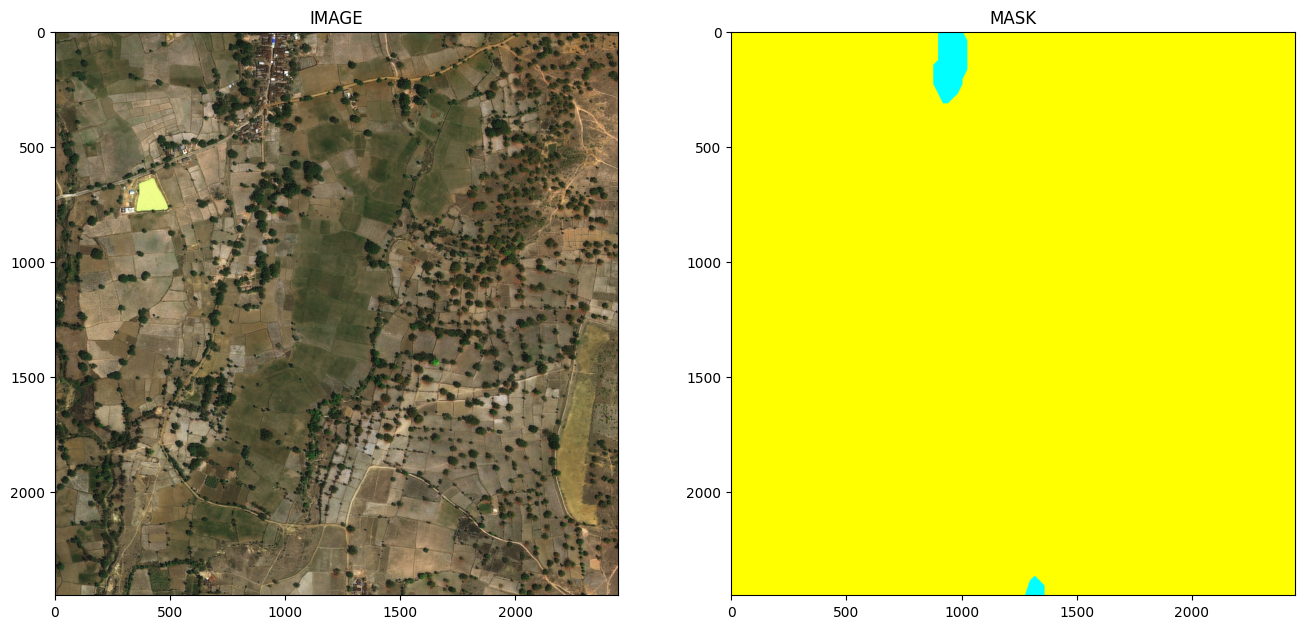

In [44]:
index = 200

sample_img = cv2.imread(pd_train.iloc[index].IMAGES)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(pd_train.iloc[index].MASKS)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

## Utility Functions

In [45]:
def rgb2category(rgb_mask):
    category_mask = np.zeros(rgb_mask.shape[:2], dtype=np.int8)
    for i, row in color_dict.iterrows():
        category_mask += (np.all(rgb_mask.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(rgb_mask.shape[:2]) * i)
    return category_mask

def category2rgb(category_mask):
    rgb_mask = np.zeros(category_mask.shape[:2] + (3,))
    for i, row in color_dict.iterrows():
        rgb_mask[category_mask==i] = (row['r'], row['g'], row['b'])
    return np.uint8(rgb_mask)

## Data Augmentations & Transformations

In [46]:
import albumentations as aug

train_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomBrightnessContrast(p=0.3)
])

test_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.RandomBrightnessContrast(p=0.3)
])

## Create PyTorch Dataset

In [47]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = cv2.imread(row.IMAGES)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.MASKS)
        mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        
        mask = rgb2category(mask)

        image = np.transpose(image, (2, 0, 1)).astype(np.float64)
        mask = np.expand_dims(mask, axis=0)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()

        return image, mask

In [48]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, pd_train, pd_val, pd_test, batch_size=10):
        super().__init__()
        self.pd_train = pd_train
        self.pd_val = pd_val
        self.pd_test = pd_test
        self.batch_size=batch_size

    def setup(self, stage=None):
        self.train_dataset = SegmentationDataset(self.pd_train, train_augment)
        self.val_dataset = SegmentationDataset(self.pd_val, test_augment)
        self.test_dataset = SegmentationDataset(self.pd_test, test_augment)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size // 2, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size // 2, shuffle=False)

In [49]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()

In [50]:
image, mask = next(iter(data_module.train_dataloader()))
image.shape, mask.shape

(torch.Size([4, 3, 320, 320]), torch.Size([4, 1, 320, 320]))

## Build Loss and Model

In [51]:
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score

class SegmentationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UnetPlusPlus(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            in_channels=3,
            classes=len(CLASSES),
            activation=None
        )
        self.criterion = DiceLoss(mode="multiclass", from_logits=False)
    
    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else: 
            return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

In [52]:
from torchinfo import summary

model = SegmentationModel()
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

c:\Users\GlowingMan\.conda\envs\py3_10\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                             Output Shape              Param #
SegmentationModel                                  [4, 7, 320, 320]          --
├─UnetPlusPlus: 1-1                                [4, 7, 320, 320]          --
│    └─ResNetEncoder: 2-1                          [4, 3, 320, 320]          --
│    │    └─Conv2d: 3-1                            [4, 64, 160, 160]         9,408
│    │    └─BatchNorm2d: 3-2                       [4, 64, 160, 160]         128
│    │    └─ReLU: 3-3                              [4, 64, 160, 160]         --
│    │    └─MaxPool2d: 3-4                         [4, 64, 80, 80]           --
│    │    └─Sequential: 3-5                        [4, 256, 80, 80]          215,808
│    │    └─Sequential: 3-6                        [4, 512, 40, 40]          1,219,584
│    │    └─Sequential: 3-7                        [4, 1024, 20, 20]         7,098,368
│    │    └─Sequential: 3-8                        [4, 2048, 10, 10]         14,964,736
│   

## Train the Model

In [53]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="unetpp-checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="unetpp-log")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [54]:
trainer.fit(model, data_module)

Missing logger folder: lightning_logs\landcover-classification-log
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params
-------------------------------------------
0 | model     | UnetPlusPlus | 49.0 M
1 | criterion | DiceLoss     | 0     
-------------------------------------------
49.0 M    Trainable params
0         Non-trainable params
49.0 M    Total params
195.946   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\GlowingMan\.conda\envs\py3_10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\GlowingMan\.conda\envs\py3_10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   1%|          | 1/121 [00:02<04:27,  0.45it/s, v_num=0]

c:\Users\GlowingMan\.conda\envs\py3_10\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: 100%|██████████| 121/121 [03:52<00:00,  0.52it/s, v_num=0, val/Loss=-1.94e+6, val/IoU=0.701, val/Accuracy=0.946, val/Precision=0.811, val/Recall=0.811, val/F1score=0.811, train/Loss=6.86e+3, train/IoU=0.557, train/Accuracy=0.916, train/Precision=0.705, train/Recall=0.705, train/F1score=0.705]

Epoch 0, global step 121: 'val/F1score' reached 0.81107 (best 0.81107), saving model to 'D:\\Repos\\crop-field-segmentation\\checkpoints\\best-checkpoint.ckpt' as top 1


Epoch 1: 100%|██████████| 121/121 [03:19<00:00,  0.61it/s, v_num=0, val/Loss=-2.07e+6, val/IoU=0.851, val/Accuracy=0.976, val/Precision=0.916, val/Recall=0.916, val/F1score=0.916, train/Loss=0.095, train/IoU=0.792, train/Accuracy=0.966, train/Precision=0.881, train/Recall=0.881, train/F1score=0.881]  

Epoch 1, global step 242: 'val/F1score' was not in top 1


Epoch 2: 100%|██████████| 121/121 [03:24<00:00,  0.59it/s, v_num=0, val/Loss=-1.92e+6, val/IoU=0.891, val/Accuracy=0.982, val/Precision=0.936, val/Recall=0.936, val/F1score=0.936, train/Loss=0.0749, train/IoU=0.900, train/Accuracy=0.985, train/Precision=0.946, train/Recall=0.946, train/F1score=0.946]

Epoch 2, global step 363: 'val/F1score' was not in top 1


Epoch 3: 100%|██████████| 121/121 [03:25<00:00,  0.59it/s, v_num=0, val/Loss=-7.58e+6, val/IoU=0.958, val/Accuracy=0.994, val/Precision=0.978, val/Recall=0.978, val/F1score=0.978, train/Loss=-3.38e+4, train/IoU=0.942, train/Accuracy=0.991, train/Precision=0.970, train/Recall=0.970, train/F1score=0.970]

Epoch 3, global step 484: 'val/F1score' was not in top 1


Epoch 4: 100%|██████████| 121/121 [03:22<00:00,  0.60it/s, v_num=0, val/Loss=-3.88e+6, val/IoU=0.992, val/Accuracy=0.999, val/Precision=0.996, val/Recall=0.996, val/F1score=0.996, train/Loss=-2.96e+5, train/IoU=0.974, train/Accuracy=0.996, train/Precision=0.987, train/Recall=0.987, train/F1score=0.987]

Epoch 4, global step 605: 'val/F1score' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 121/121 [03:23<00:00,  0.60it/s, v_num=0, val/Loss=-3.88e+6, val/IoU=0.992, val/Accuracy=0.999, val/Precision=0.996, val/Recall=0.996, val/F1score=0.996, train/Loss=-2.96e+5, train/IoU=0.974, train/Accuracy=0.996, train/Precision=0.987, train/Recall=0.987, train/F1score=0.987]


## Test the Model

In [55]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GlowingMan\.conda\envs\py3_10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 101/101 [01:24<00:00,  1.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/Accuracy         0.9988889694213867
      test/F1score          0.9961110353469849
        test/IoU            0.9922998547554016
        test/Loss           0.01825341023504734
     test/Precision         0.9961110353469849
       test/Recall          0.9961110353469849
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/Loss': 0.01825341023504734,
  'test/IoU': 0.9922998547554016,
  'test/Accuracy': 0.9988889694213867,
  'test/Precision': 0.9961110353469849,
  'test/Recall': 0.9961110353469849,
  'test/F1score': 0.9961110353469849}]

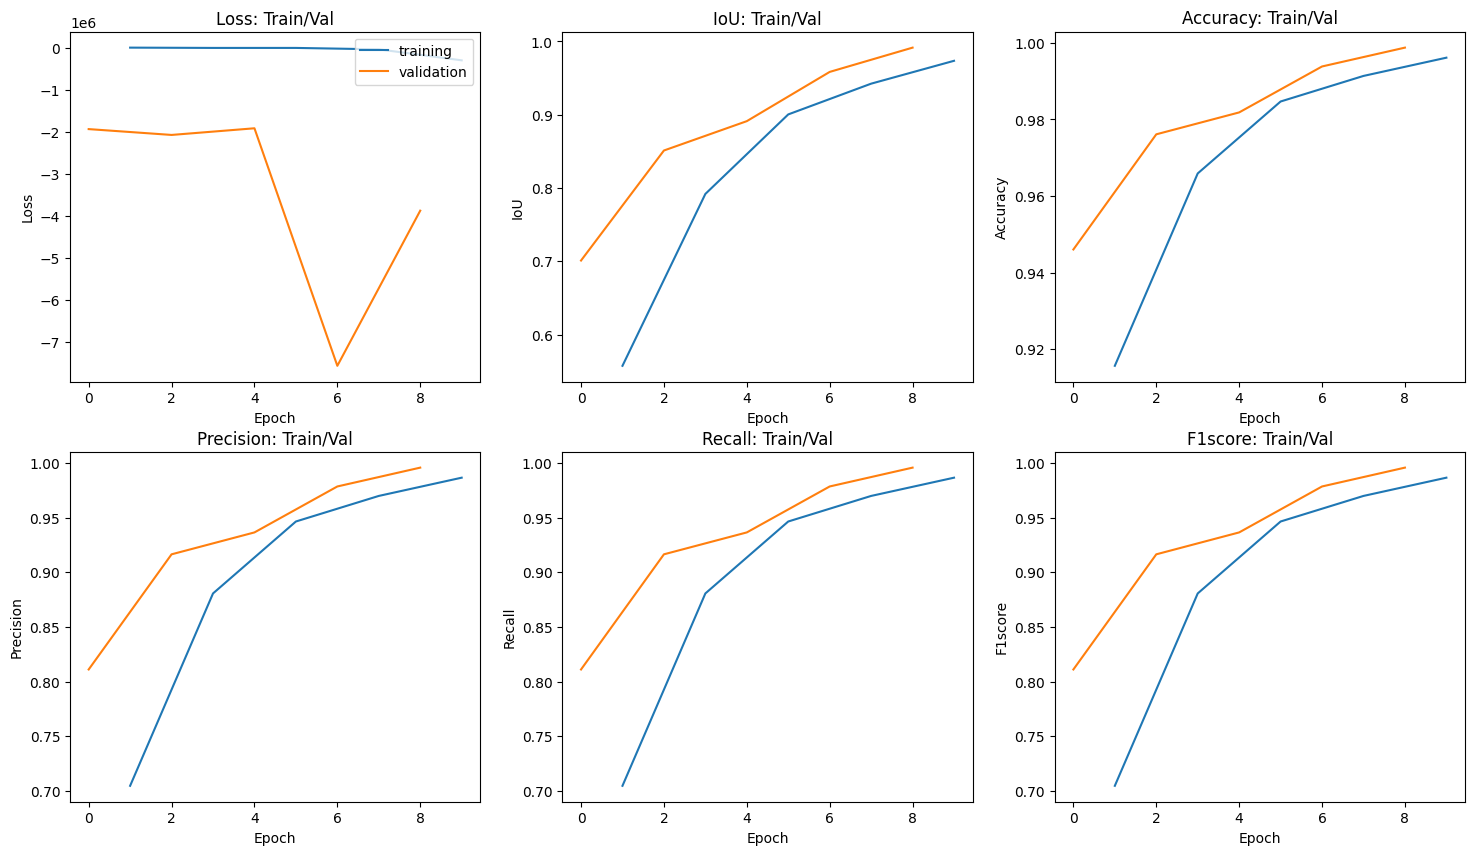

In [56]:
metrics = pd.read_csv("./lightning_logs/unetpp-log/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")

In [2]:
# Print ground truth mask and predicted mask
import random

sample = [random.randrange(len(pd_test)) for i in range(10)]

for index in sample:
    sample_img = cv2.imread(pd_test.iloc[index].IMAGES)
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    sample_msk = cv2.imread(pd_test.iloc[index].MASKS)
    sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

    image = cv2.resize(sample_img, (IMAGE_SIZE, IMAGE_SIZE))
    image = np.transpose(image, (2, 0, 1)).astype(np.float64)
    image = torch.Tensor(image) / 255.0
    image = image.unsqueeze(0)

    model.eval()
    outputs = model(image)
    outputs = outputs.argmax(dim=1).squeeze(0).detach().cpu().numpy()
    outputs = category2rgb(outputs)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))

    ax1.set_title('IMAGE')
    ax1.imshow(sample_img)

    ax2.set_title('PREDICTED MASK')
    ax2.imshow(outputs)

    ax3.set_title('GROUND TRUTH MASK')
    ax3.imshow(sample_msk)

plt.show()

NameError: name 'pd_test' is not defined